In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json

def yolo_to_ground_truth(labels_dir, output_json, class_names):
    """
    Convierte archivos de etiquetas YOLO en un archivo JSON de ground truth.

    :param labels_dir: Carpeta con archivos de etiquetas YOLO.
    :param output_json: Nombre del archivo de salida JSON.
    :param class_names: Lista con los nombres de las clases.
    """
    ground_truth = {}

    for label_file in os.listdir(labels_dir):
        if label_file.endswith(".txt"):
            image_name = label_file.replace(".txt", ".jpg")  # Ajusta según el dataset
            label_path = os.path.join(labels_dir, label_file)

            with open(label_path, "r") as file:
                objects = []
                for line in file:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  # Ignorar líneas incorrectas

                    class_id, x_center, y_center, width, height = map(float, parts)
                    class_name = class_names[int(class_id)]

                    objects.append({
                        "bbox": [x_center, y_center, width, height],  # En coordenadas normalizadas
                        "class": class_name,
                        "confidence": 1.0  # En ground truth, la confianza es 100%
                    })

                if objects:
                    ground_truth[image_name] = objects

    with open(output_json, "w") as json_file:
        json.dump(ground_truth, json_file, indent=4)

    print(f"Ground truth guardado en {output_json}")

# Ejemplo de uso
labels_folder = "/content/drive/MyDrive/proyectoml/dataset/test/labels"
output_file = "/content/drive/MyDrive/proyectoml/dataset/ground_truth.json"
class_names = ['Chaetomium', 'Cladosporium', 'Coprinus', 'Curvularia', 'Ganoderma']  # Modifica con tus clases

yolo_to_ground_truth(labels_folder, output_file, class_names)


Ground truth guardado en /content/drive/MyDrive/proyectoml/dataset/ground_truth.json


### **Bibliotecas necesarias**

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from collections import defaultdict

### **Se carga la información de las predicciones de los dos modelos y  las etiquetas reales con las que se comparan las predicciones del modelo**

In [3]:
path_gt = "/content/drive/MyDrive/proyectoml/dataset/ground_truth.json"
path_modelo1 = "/content/drive/MyDrive/proyectoml/dataset/yolo_predictions.json"
path_modelo2 = "/content/drive/MyDrive/proyectoml/dataset/yolo_predictions.json"

# Cargar los archivos JSON
with open(path_modelo1) as f:
    modelo1_data = json.load(f)

with open(path_modelo2) as f:
    modelo2_data = json.load(f)

with open(path_gt) as f:
    ground_truth_data = json.load(f)

### **Funciones utiles**

In [4]:
# Función para contar las detecciones por clase en cada archivo
def contar_detecciones_por_clase(data):
    conteo = {}
    for archivo, detecciones in data.items():
        clases = [d["class"] for d in detecciones]
        conteo[archivo] = {clase: clases.count(clase) for clase in set(clases)}
    return conteo

# Crear DataFrames para mostrar en tabla
def generar_dataframe(conteo):
    df = pd.DataFrame([{**{'archivo': archivo}, **conteo.get(archivo, {})} for archivo in conteo])
    #df = df.fillna(0).astype(int)
    df.iloc[:, 1:] = df.iloc[:, 1:].fillna(0).astype(int)
    return df

def cargar_clases(json_path):
    """Carga un archivo JSON y cuenta cuántas veces aparece cada clase en cada imagen."""
    with open(json_path, 'r') as f:
        data = json.load(f)

    conteo = defaultdict(int)
    for imagen, objetos in data.items():
        for obj in objetos:
            clase = obj["class"]
            conteo[clase] += 1  # Contar cuántas veces aparece cada clase

    return conteo

def calcular_metricas(conteo_modelo, conteo_gt):
    """Calcula precisión y recall basados en los conteos de clases."""
    clases = set(conteo_modelo.keys()) | set(conteo_gt.keys())
    resultado = {"precision": 0, "recall": 0, "class_comparison": {}}

    total_tp, total_fp, total_fn = 0, 0, 0

    for clase in clases:
        tp = min(conteo_modelo.get(clase, 0), conteo_gt.get(clase, 0))  # Verdaderos Positivos: lo que coincida
        fp = max(0, conteo_modelo.get(clase, 0) - tp)  # Falsos Positivos: detecciones extra
        fn = max(0, conteo_gt.get(clase, 0) - tp)  # Falsos Negativos: detecciones faltantes

        total_tp += tp
        total_fp += fp
        total_fn += fn

        resultado["class_comparison"][clase] = {"tp": tp, "fp": fp, "fn": fn}

    if total_tp + total_fp > 0:
        resultado["precision"] = total_tp / (total_tp + total_fp)
    if total_tp + total_fn > 0:
        resultado["recall"] = total_tp / (total_tp + total_fn)

    return resultado

### **Comparaciones por clase**

In [5]:

# Contar detecciones por clase para cada dataset
conteo_modelo1 = contar_detecciones_por_clase(modelo1_data)
conteo_modelo2 = contar_detecciones_por_clase(modelo2_data)
conteo_ground_truth = contar_detecciones_por_clase(ground_truth_data)

# Obtener todas las clases únicas
clases = set()
for data in [conteo_modelo1, conteo_modelo2, conteo_ground_truth]:
    for conteo in data.values():
        clases.update(conteo.keys())
clases = sorted(clases)

df_modelo1 = generar_dataframe(conteo_modelo1)
df_modelo2 = generar_dataframe(conteo_modelo2)
df_ground_truth = generar_dataframe(conteo_ground_truth)

# Combinar en una sola tabla
df_comparacion = df_ground_truth.copy()
df_comparacion.columns = ['archivo'] + [f"GT_{col}" for col in df_comparacion.columns[1:]]
df_modelo1.columns = ['archivo'] + [f"M1_{col}" for col in df_modelo1.columns[1:]]
df_modelo2.columns = ['archivo'] + [f"M2_{col}" for col in df_modelo2.columns[1:]]

df_comparacion = df_comparacion.merge(df_modelo1, on="archivo", how="outer").merge(df_modelo2, on="archivo", how="outer")
df_comparacion.iloc[:, 1:] = df_comparacion.iloc[:, 1:].fillna(0).astype(int)




df_comparacion




,archivo,GT_Coprinus,GT_Chaetomium,GT_Cladosporium,GT_Curvularia,GT_Ganoderma,M1_Coprinus,M1_Cladosporium,M1_Chaetomium,M1_Curvularia,M1_Ganoderma,M2_Coprinus,M2_Cladosporium,M2_Chaetomium,M2_Curvularia,M2_Ganoderma
0,10_1_jpg.rf.da3121c4849f697d046f20dd834471ca.jpg,0.0,0.0,8.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0
1,10_2_jpg.rf.13731b6162180a11a145be486422d30b.jpg,1.0,2.0,0.0,0.0,1.0,4.0,0.0,2.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0
2,10_2_jpg.rf.442d8cdbaa67182827ed071c52fe8c23.jpg,1.0,2.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0
3,10_3_jpg.rf.117d445df543113c99ad66959088c6c9.jpg,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
4,11_2_jpg.rf.4475bd137eb597c4eb23d3e0e51833e5.jpg,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,9_1_jpg.rf.31c803ef16cfb5b6b326aecedd3cba75.jpg,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
304,9_1_jpg.rf.a0b8461cb6c7e3d20bf9a06a8adfed0e.jpg,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
305,9_3_jpg.rf.d955ed706e839c0aa3f1d13a498de7f5.jpg,0.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
306,9_4_jpg.rf.2e3c653162e4d0b081de60dd999d7e76.jpg,0.0,0.0,3.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0


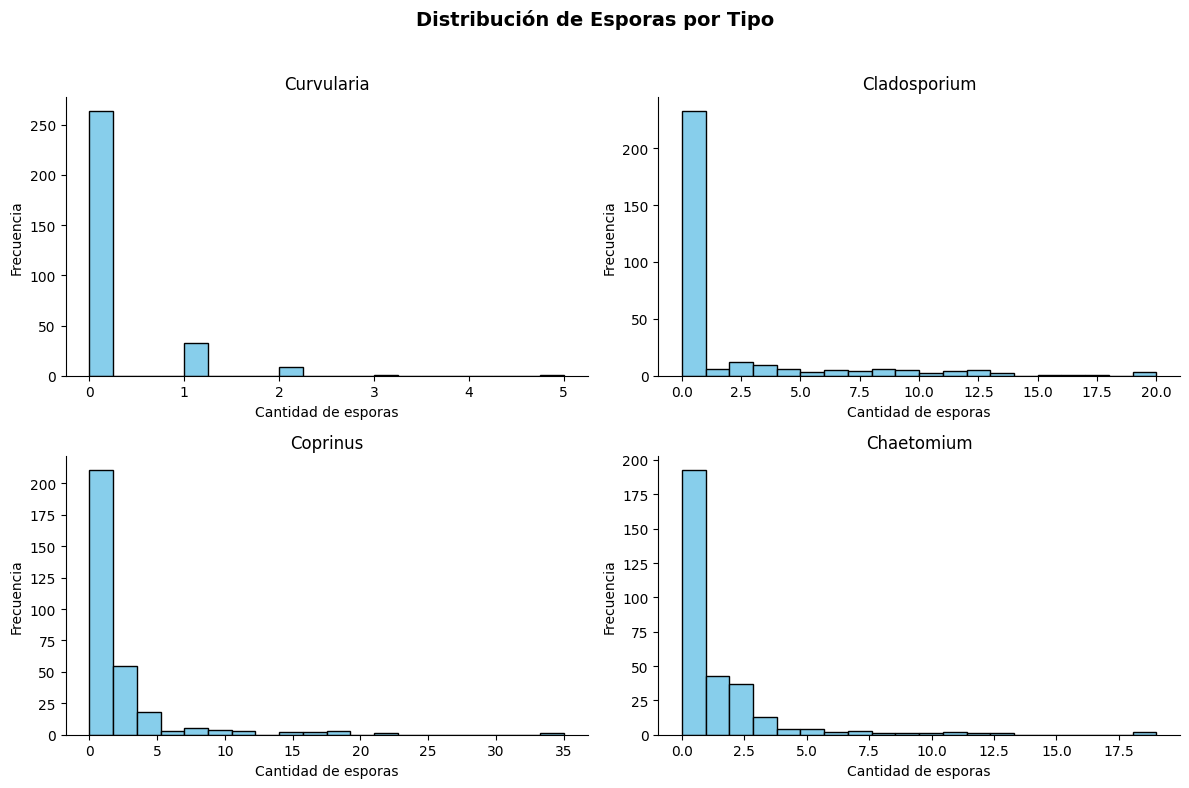

In [9]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes para los subgráficos
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Distribución de Esporas por Tipo", fontsize=14, fontweight='bold')

# Definir las clases y los títulos de los gráficos
clases_t = ["GT_Curvularia", "GT_Cladosporium", "GT_Coprinus", "GT_Chaetomium"]
titulos = ["Curvularia", "Cladosporium", "Coprinus", "Chaetomium"]

# Iterar sobre los ejes y dibujar los histogramas
tuple_axes = [(0, 0), (0, 1), (1, 0), (1, 1)]
for ax, clase, titulo in zip(tuple_axes, clases_t, titulos):
    axes[ax].hist(df_comparacion[clase], bins=20, color='skyblue', edgecolor='black')
    axes[ax].set_title(f"{titulo}", fontsize=12)
    axes[ax].spines[['top', 'right']].set_visible(False)
    axes[ax].set_xlabel("Cantidad de esporas")
    axes[ax].set_ylabel("Frecuencia")

# Ajustar el espacio entre gráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


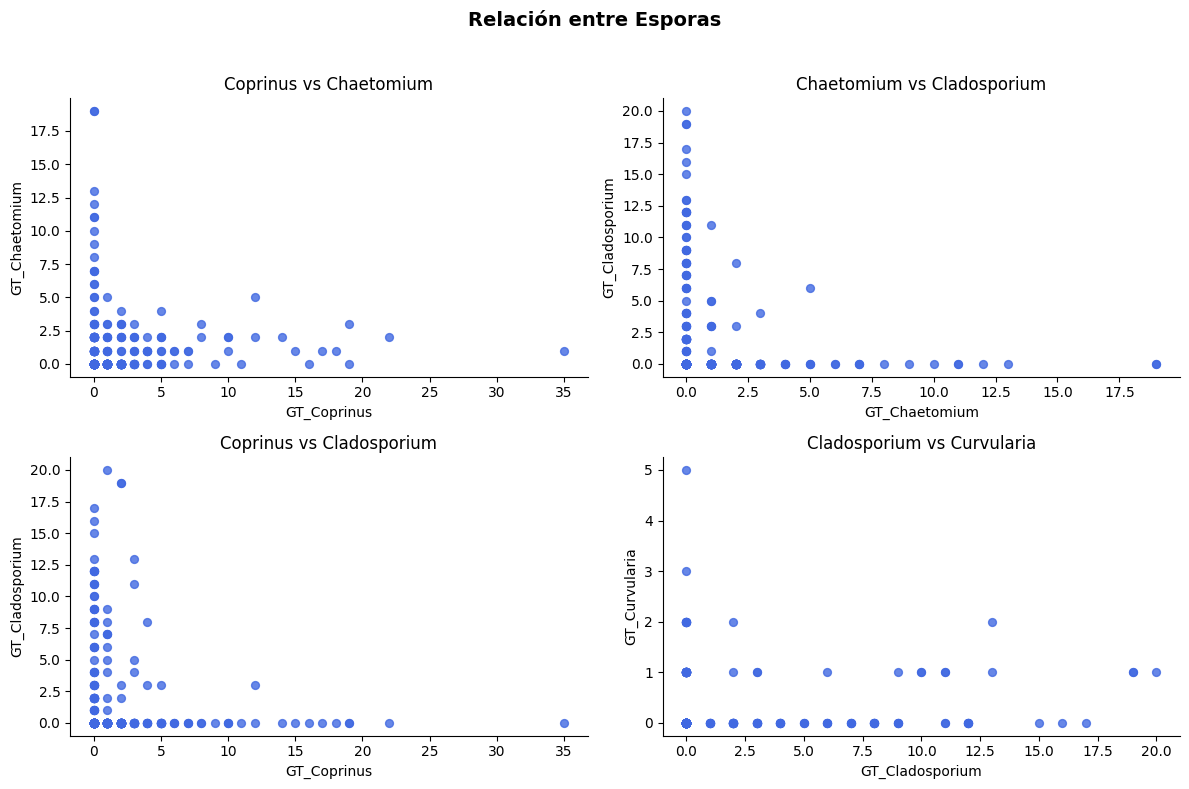

In [10]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes para los subgráficos
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Relación entre Esporas", fontsize=14, fontweight='bold')

# Definir las combinaciones de clases para los gráficos de dispersión
scatter_pairs = [
    ("GT_Coprinus", "GT_Chaetomium"),
    ("GT_Chaetomium", "GT_Cladosporium"),
    ("GT_Coprinus", "GT_Cladosporium"),
    ("GT_Cladosporium", "GT_Curvularia")
]

titulos = [
    "Coprinus vs Chaetomium",
    "Chaetomium vs Cladosporium",
    "Coprinus vs Cladosporium",
    "Cladosporium vs Curvularia"
]

# Iterar sobre los ejes y dibujar los gráficos de dispersión
tuple_axes = [(0, 0), (0, 1), (1, 0), (1, 1)]
for ax, (x_col, y_col), titulo in zip(tuple_axes, scatter_pairs, titulos):
    axes[ax].scatter(df_comparacion[x_col], df_comparacion[y_col], s=32, alpha=0.8, color='royalblue')
    axes[ax].set_title(titulo, fontsize=12)
    axes[ax].spines[['top', 'right']].set_visible(False)
    axes[ax].set_xlabel(x_col)
    axes[ax].set_ylabel(y_col)

# Ajustar el espacio entre gráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

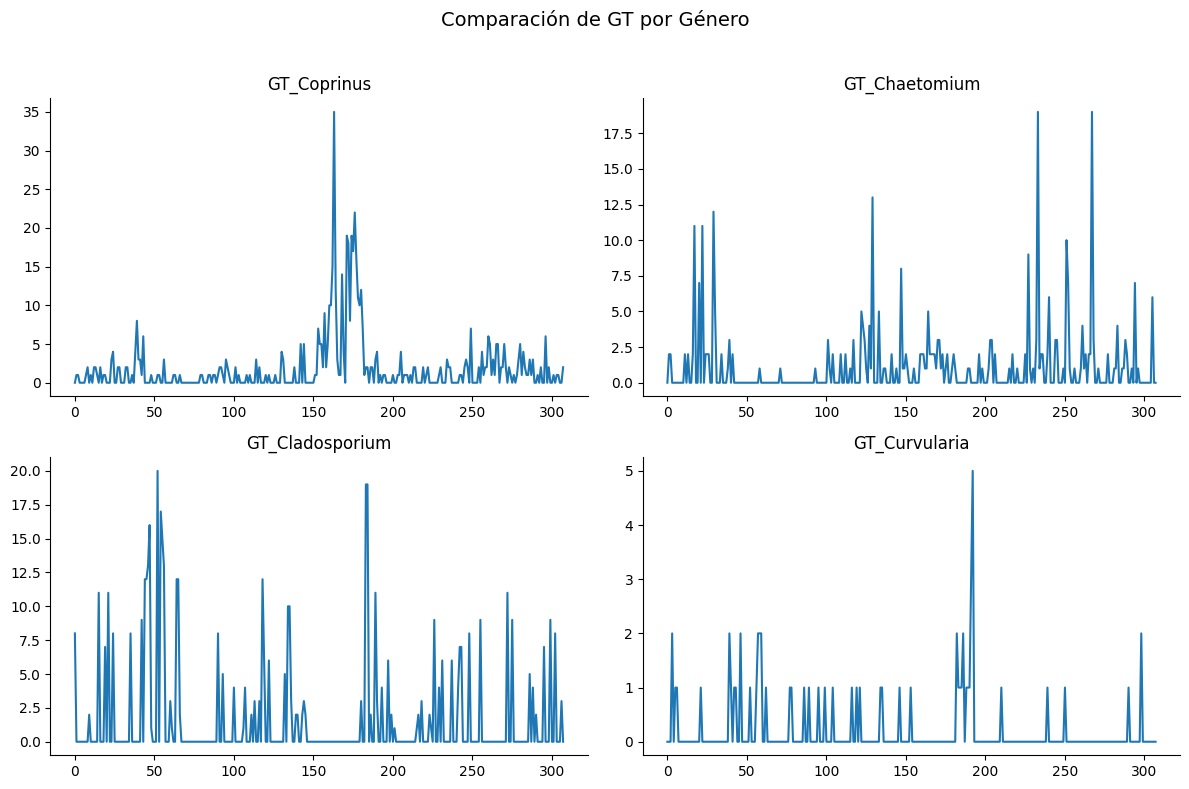

In [11]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes con una disposición de 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparación de GT por Género', fontsize=14)

# Lista de géneros y sus posiciones en la cuadrícula
generos = ['GT_Coprinus', 'GT_Chaetomium', 'GT_Cladosporium', 'GT_Curvularia']

ejes = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Iterar sobre cada género y asignar a un subplot
for ax, genero, pos in zip(axes.flat, generos, ejes):
    df_comparacion[genero].plot(kind='line', ax=ax, title=genero)
    ax.spines[['top', 'right']].set_visible(False)

# Ajustar diseño para evitar superposición de títulos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## **Comparación de Precisión y Recall por Modelo**

In [12]:
from tabulate import tabulate
# Cargar conteos
conteo_gt = cargar_clases(path_gt)
conteo_modelo1 = cargar_clases(path_modelo1)
conteo_modelo2 = cargar_clases(path_modelo2)

# Calcular métricas
metricas_modelo1 = calcular_metricas(conteo_modelo1, conteo_gt)
metricas_modelo2 = calcular_metricas(conteo_modelo2, conteo_gt)

# Extraer las métricas generales
precision_recall = pd.DataFrame({
    'Métrica': ['Precision', 'Recall'],
    'Modelo 1': [metricas_modelo1['precision'], metricas_modelo1['recall']],
    'Modelo 2': [metricas_modelo2['precision'], metricas_modelo2['recall']]
})

# Extraer la comparación por clases y convertirla en DataFrame
class_comparison_1 = pd.DataFrame(metricas_modelo1['class_comparison']).T
class_comparison_2 = pd.DataFrame(metricas_modelo2['class_comparison']).T

# Renombrar columnas para claridad
class_comparison_1.columns = ['TP Modelo 1', 'FP Modelo 1', 'FN Modelo 1']
class_comparison_2.columns = ['TP Modelo 2', 'FP Modelo 2', 'FN Modelo 2']

# Unir ambas comparaciones
df_class_comparison = pd.concat([class_comparison_1, class_comparison_2], axis=1)

# Combinar todas las métricas en un solo DataFrame
final_df = pd.concat([precision_recall.set_index('Métrica'), df_class_comparison])

# Mostrar la tabla en un formato bonito
print(tabulate(final_df, headers='keys', tablefmt='fancy_grid'))

╒══════════════╤════════════╤════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│              │   Modelo 1 │   Modelo 2 │   TP Modelo 1 │   FP Modelo 1 │   FN Modelo 1 │   TP Modelo 2 │   FP Modelo 2 │   FN Modelo 2 │
╞══════════════╪════════════╪════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ Precision    │   0.779444 │   0.779444 │           nan │           nan │           nan │           nan │           nan │           nan │
├──────────────┼────────────┼────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ Recall       │   0.899936 │   0.899936 │           nan │           nan │           nan │           nan │           nan │           nan │
├──────────────┼────────────┼────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ Curvularia   │ nan       

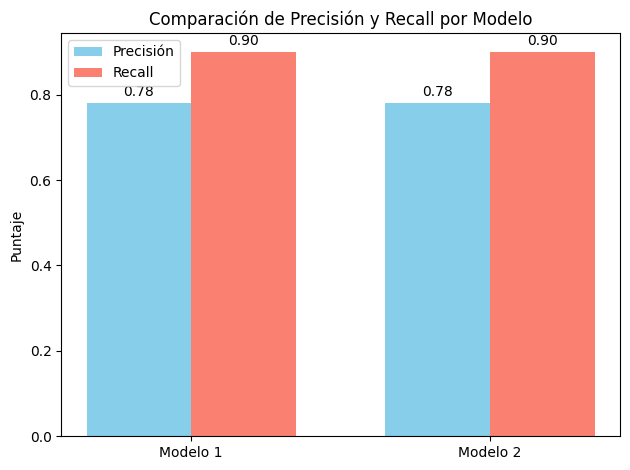

In [13]:
def graficar_metricas_globales(metricas_modelo1, metricas_modelo2):
    """
    Grafica las métricas globales (precisión y recall) de dos modelos.
    """
    modelos = ['Modelo 1', 'Modelo 2']
    precisiones = [metricas_modelo1['precision'], metricas_modelo2['precision']]
    recalls = [metricas_modelo1['recall'], metricas_modelo2['recall']]

    x = np.arange(len(modelos))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, precisiones, width, label='Precisión', color='skyblue')
    rects2 = ax.bar(x + width/2, recalls, width, label='Recall', color='salmon')

    ax.set_ylabel('Puntaje')
    ax.set_title('Comparación de Precisión y Recall por Modelo')
    ax.set_xticks(x)
    ax.set_xticklabels(modelos)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puntos vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()



graficar_metricas_globales(metricas_modelo1, metricas_modelo2)

### **Graficar comparaciones por clase**

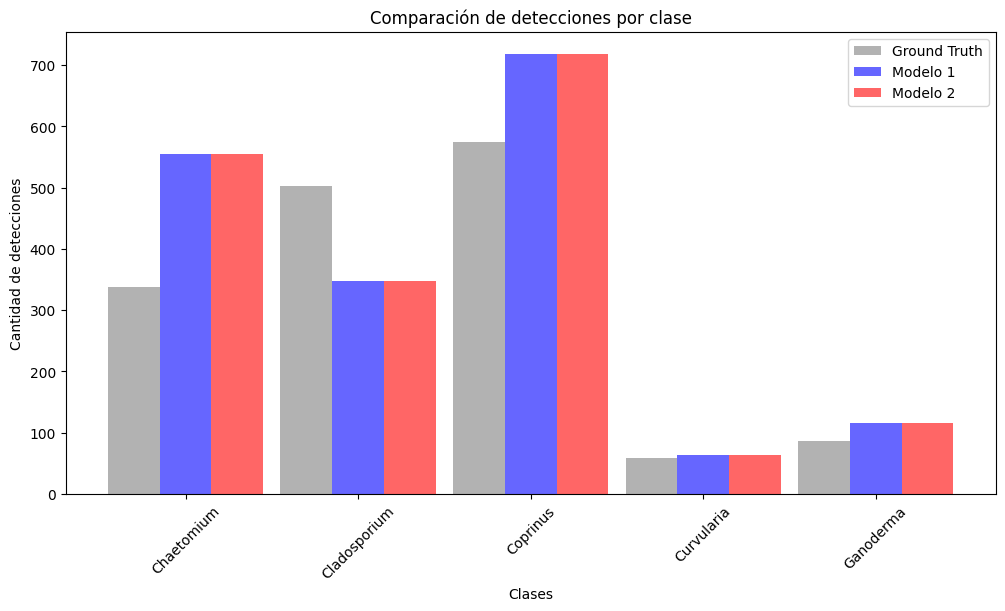

In [14]:
def graficar_comparacion_clases(df_comparacion, clases):
    """
    Genera un gráfico de barras que compara las detecciones por clase entre el ground truth
    y los dos modelos.

    :param df_comparacion: DataFrame con los conteos por clase.
    :param clases: Lista de nombres de clases.
    """

    plt.figure(figsize=(12, 6))

    x = np.arange(len(clases))  # Posiciones en el eje X
    width = 0.3  # Ancho de cada barra

    valores_gt = [df_comparacion[f"GT_{clase}"].sum() if f"GT_{clase}" in df_comparacion else 0 for clase in clases]
    valores_m1 = [df_comparacion[f"M1_{clase}"].sum() if f"M1_{clase}" in df_comparacion else 0 for clase in clases]
    valores_m2 = [df_comparacion[f"M2_{clase}"].sum() if f"M2_{clase}" in df_comparacion else 0 for clase in clases]

    # Dibujar las barras una al lado de la otra
    plt.bar(x - width, valores_gt, width, color='gray', alpha=0.6, label='Ground Truth')
    plt.bar(x, valores_m1, width, color='blue', alpha=0.6, label='Modelo 1')
    plt.bar(x + width, valores_m2, width, color='red', alpha=0.6, label='Modelo 2')

    plt.xlabel("Clases")
    plt.ylabel("Cantidad de detecciones")
    plt.title("Comparación de detecciones por clase")
    plt.xticks(x, clases, rotation=45)  # Ajustar etiquetas del eje X
    plt.legend()
    plt.show()

clases = ['Chaetomium', 'Cladosporium', 'Coprinus', 'Curvularia', 'Ganoderma']
graficar_comparacion_clases(df_comparacion, clases)


In [15]:
y_true, y_pred_m1, y_pred_m2 = [], [], []

for archivo in df_comparacion["archivo"]:
    for clase in clases:
        # Obtener valores de GT y modelos
        valor_gt = df_comparacion.loc[df_comparacion["archivo"] == archivo, f"GT_{clase}"].values
        valor_m1 = df_comparacion.loc[df_comparacion["archivo"] == archivo, f"M1_{clase}"].values
        valor_m2 = df_comparacion.loc[df_comparacion["archivo"] == archivo, f"M2_{clase}"].values

        # Convertir a enteros asegurando que existan valores
        cantidad_gt = int(valor_gt[0]) if len(valor_gt) > 0 else 0
        cantidad_m1 = int(valor_m1[0]) if len(valor_m1) > 0 else 0
        cantidad_m2 = int(valor_m2[0]) if len(valor_m2) > 0 else 0

        # y_true se llena solo con la cantidad de la verdad de terreno (GT)
        y_true.extend([clase] * cantidad_gt)

        # Modelo 1 predice clases, pero puede agregar falsos positivos
        y_pred_m1.extend([clase] * cantidad_m1)

        # Modelo 2 predice clases, pero puede agregar falsos positivos
        y_pred_m2.extend([clase] * cantidad_m2)

# Verificar que las longitudes ahora coinciden
print("Longitudes:", len(y_true), len(y_pred_m1), len(y_pred_m2))

falsos_positivos_m1 = max(0, len(y_pred_m1) - len(y_true))
falsos_positivos_m2 = max(0, len(y_pred_m2) - len(y_true))

print(f"Falsos positivos en M1: {falsos_positivos_m1}")
print(f"Falsos positivos en M2: {falsos_positivos_m2}")

Longitudes: 1559 1800 1800
Falsos positivos en M1: 241
Falsos positivos en M2: 241


Tenemos más predicciones que etiquetas reales, lo que indica que el modelo está generando más detecciones de las que existen en el `ground_truth.json`.  

### **Causas posibles del problema**  
1. **Falsos positivos excesivos** → El modelo está detectando demasiadas esporas que no están en el `ground_truth.json`.  
2. **Desajuste en la cantidad de etiquetas** → `y_true` tiene 1559 valores, pero `y_pred` tiene 1800, lo que significa que el modelo está haciendo más predicciones de las que debería.  
3. **Formato incorrecto de los datos** → Tal vez `y_pred` no está alineado correctamente con `y_true`, o hay elementos duplicados en `y_pred`.  
4. **Errores en la generación de `y_true`** → Es posible que el `ground_truth.json` tenga datos faltantes, lo que haría que `y_true` sea más corto de lo esperado.  

### **Solución posible**  
Antes de calcular la matriz de confusión, asegúrar de que `y_true` y `y_pred` tengan la misma longitud.
Si hay demasiadas detecciones extras, el problema puede estar en el umbral de confianza del modelo. Se puede ajustar este umbral para filtrar predicciones de baja confianza.  


In [16]:
if len(y_pred_m1) > len(y_true):
    y_pred_m1 = y_pred_m1[:len(y_true)]
if len(y_pred_m2) > len(y_true):
    y_pred_m2 = y_pred_m2[:len(y_true)]

# Verificar que las longitudes ahora coinciden
print("Longitudes:", len(y_true), len(y_pred_m1), len(y_pred_m2))

falsos_positivos_m1 = max(0, len(y_pred_m1) - len(y_true))
falsos_positivos_m2 = max(0, len(y_pred_m2) - len(y_true))

print(f"Falsos positivos en M1: {falsos_positivos_m1}")
print(f"Falsos positivos en M2: {falsos_positivos_m2}")


Longitudes: 1559 1559 1559
Falsos positivos en M1: 0
Falsos positivos en M2: 0


### **Calcular métricas**

In [20]:
# Calcular métricas
precision_m1 = precision_score(y_true, y_pred_m1, average='weighted', zero_division=0)
recall_m1 = recall_score(y_true, y_pred_m1, average='weighted', zero_division=0)
f1_m1 = f1_score(y_true, y_pred_m1, average='weighted', zero_division=0)

precision_m2 = precision_score(y_true, y_pred_m2, average='weighted', zero_division=0)
recall_m2 = recall_score(y_true, y_pred_m2, average='weighted', zero_division=0)
f1_m2 = f1_score(y_true, y_pred_m2, average='weighted', zero_division=0)

# Crear DataFrame para formatear en tabla
df_metrics = pd.DataFrame({
    "Métrica": ["Precisión", "Recall", "F1-score"],
    "Modelo 1": [f"{precision_m1:.2f}", f"{recall_m1:.2f}", f"{f1_m1:.2f}"],
    "Modelo 2": [f"{precision_m2:.2f}", f"{recall_m2:.2f}", f"{f1_m2:.2f}"]
})

# Imprimir tabla
print(tabulate(df_metrics, headers="keys", tablefmt="fancy_grid"))


╒════╤═══════════╤════════════╤════════════╕
│    │ Métrica   │   Modelo 1 │   Modelo 2 │
╞════╪═══════════╪════════════╪════════════╡
│  0 │ Precisión │       0.39 │       0.39 │
├────┼───────────┼────────────┼────────────┤
│  1 │ Recall    │       0.37 │       0.37 │
├────┼───────────┼────────────┼────────────┤
│  2 │ F1-score  │       0.38 │       0.38 │
╘════╧═══════════╧════════════╧════════════╛


### **Crear matrices de confusión**

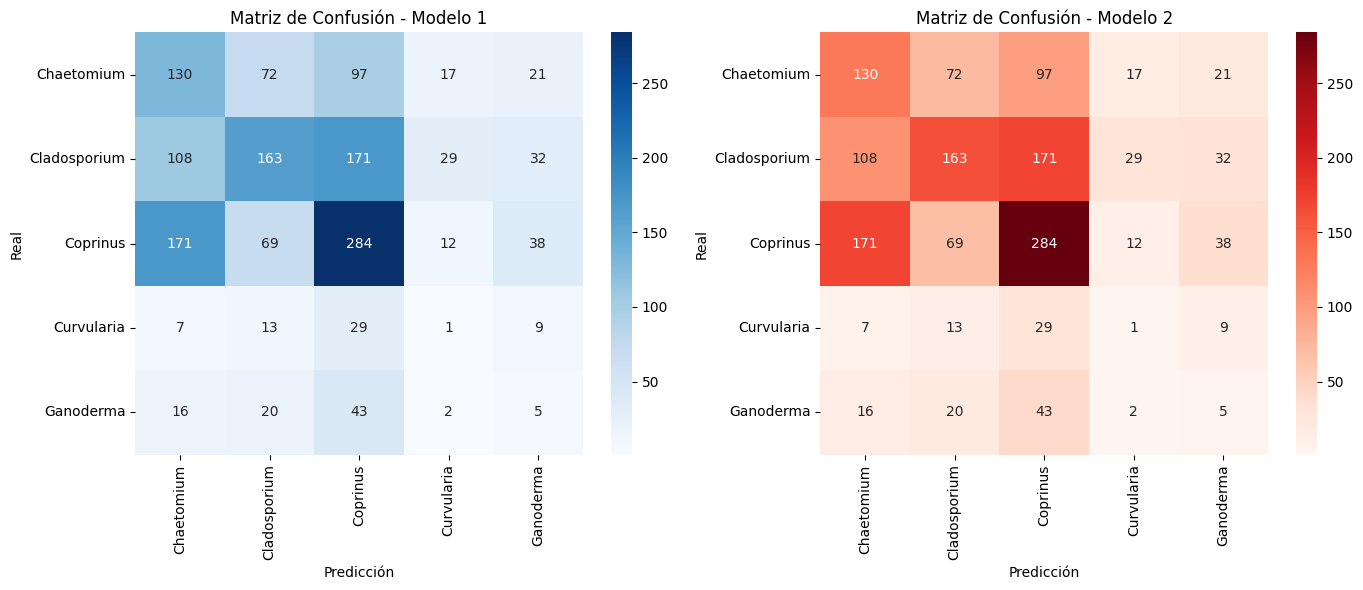

In [21]:
# Crear matrices de confusión
cm_m1 = confusion_matrix(y_true, y_pred_m1, labels=clases)
cm_m2 = confusion_matrix(y_true, y_pred_m2, labels=clases)

# Graficar matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_m1, annot=True, fmt="d", xticklabels=clases, yticklabels=clases, ax=axes[0], cmap="Blues")
axes[0].set_title("Matriz de Confusión - Modelo 1")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_m2, annot=True, fmt="d", xticklabels=clases, yticklabels=clases, ax=axes[1], cmap="Reds")
axes[1].set_title("Matriz de Confusión - Modelo 2")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()
